# Lecture 11: Basics of Prescriptive Analytics

## Contents
- [Imports](#section1)
- [Introduction to linear optimization](#section2)
    - [Terminology and notations](#subsection2.1)
    - [Beyond linear](#subsection2.2)
    - [RSOME for Linear programming](#subsection2.3)
- [Decision-making under uncertainty](#section3)
- [Case study](#section4)

## Imports <a id="section1"></a>

In this lecture, we will introduce two external packages:
- RSOME (Robust Stochastic Optimization Made Easy). You may find more details from the official website [here](https://xiongpengnus.github.io/rsome/) or the [GitHub Repository](https://github.com/XiongPengNUS/rsome) 

- OR-Tools: an open-source optimization solver developed by Google. You may find more details form [here](https://developers.google.com/optimization)

In [1]:
!pip install rsome
!pip install ortools

  Using cached https://files.pythonhosted.org/packages/9c/7f/71c528368229f34aa6618e3eb17a015f77b02034e89fe6625a0e05beadd1/rsome-0.1.5-py3-none-any.whl


In [4]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt

from rsome import ro
from rsome import ort_solver as ort

## Introduction to linear optimization <a id="section2"></a>

### Terminology and notations <a id="subsection2.1"></a>

<div class="alert alert-block alert-success">
<b>Example 1:</b>  
    Consider the following linear programming problem:
\begin{align}
\text{minimize}~&2x_1 - x_2 + 4x_3   \\
\text{subject to}~& x_1 + x_2 + x_4 \leq 2 \\
& 3x_2 - x_3 = 5 \\
& x_3 + x_4 \geq 3 \\
& x_1 \geq 0 \\
& x_3 \leq 0.
\end{align}
</div>

In this example:
- Variables $x_1$, $x_2$, $x_3$, and $x_4$ are **decision variables** whose values are to be chosen to minimize the linear cost function $2x_1 - x_2 + 4x_3$, while a number of linear equalities and inequalities are satisfied. 
- The cost function $2x_1 - x_2 + 4x_3$ is called an **objective function**. The notation 'minimize'(or 'maximize') is sometimes replaced by 'min' (or 'max'). 
- The equalities and inequalities are called the **constraints** of the linear programming model. The notation 'subject to' is sometimes replaced by 's.t.'. 
- A set of decision variable values that satisfy all of the constraints is called a **feasible solution**. 
- The set of all feasible solutions is called the **feasible set** or **feasible region**. 
- A feasible solution that minimizes (or maximizes) the objective function is called an **optimal feasible solution**, or simply an **optimal solution**. 
- If no feasible solution can be found, then the problem is called **infeasible**. 
- For a minimization (or maximization) problem, if the objective function can be arbitrarily small (or arbitrarily large), then we call it **unbounded**. 

It is easy to show that the following objective functions or constraints are equivalent:

- $\max~\sum_{i=1}^nc_ix_i \Longleftrightarrow \min -\sum_{i=1}^nc_ix_i$
- $\min~\sum_{i=1}^nc_ix_i \Longleftrightarrow \begin{cases}\min~z \\ z\geq \sum_{i=1}^nc_ix_i\end{cases}$
- $\sum_{i=1}^na_ix_i \geq b \Longleftrightarrow - \sum_{i=1}^na_ix_i \leq -b$
- $\sum_{i=1}^na_ix_i = b \Longleftrightarrow \begin{cases}\sum_{i=1}^na_ix_i \leq b \\ \sum_{i=1}^na_ix_i \geq b\end{cases} \Longleftrightarrow \begin{cases}\sum_{i=1}^na_ix_i \leq b \\ -\sum_{i=1}^na_ix_i \leq -b.\end{cases}$


Based on the equivalent expressions above, any linear programming problems may be written as the general formula below

\begin{align}
\min ~& \sum\limits_{i=1}^n c_i x_i \\
\text{s.t.}~& \sum\limits_{i=1}^n a_{1i}x_i \leq b_1 \\
& \vdots \\
&\sum\limits_{i=1}^n a_{mi}x_i \leq b_m,
\end{align}
or equivalently, a compact matrix form
\begin{align}
\min ~&\pmb{c}^T\pmb{x} \\
\text{s.t.}~ &\pmb{Ax} \leq \pmb{b}
\end{align}

Some solvers only solve problems in the general form (or something similar), so some transformations may be required if the problem does not follow the general form. 

Can you write the linear programming problem in **Example 1** as the general form?

\begin{align}
\text{min}~&2x_1 - x_2 + 4x_3   \\
\text{s.t.}~& x_1 + x_2 + x_4 \leq 2 \\
& 3x_2 - x_3 \leq 5 \\
& -3x_2 + x_3 \leq -5 \\
& -x_3 - x_4 \leq -3 \\
& -x_1 \leq 0 \\
& x_3 \leq 0.
\end{align}

### Beyond linear <a id="subsection2.2"></a>

The linear programming model is in fact much more versatile than its name suggests. Some nonlinear functions can be well approximated and addressed in linear programming problems.  

<div class="alert alert-block alert-danger">
<b>Notes:</b> 
    <li> A function $g$ is called <b>convex</b> if for every $\pmb{x}$, $\pmb{y}$ and every $0 \leq \lambda \leq 1$, we have $g(\lambda\pmb{x} + (1-\lambda)\pmb{x}) \leq \lambda g(\pmb{x}) + (1-\lambda)g(\pmb{y})$.
    <li> A function $g$ is called <b>concave</b> if for every $\pmb{x}$, $\pmb{y}$ and every $0 \leq \lambda \leq 1$, we have $g(\lambda\pmb{x} + (1-\lambda)\pmb{x}) \geq \lambda g(\pmb{x}) + (1-\lambda)g(\pmb{y})$.
</div>

<img src="https://i.stack.imgur.com/GNBZ4.png" width=450>


The graph above also tells us that if the function $g(\pmb{x})$ is convex (or concave), then $-g(\pmb{x})$ is concave (or convex). 

If a function $g$ is convex, then the following objective functions and constraints can be approximated and incorporated into a linear programming problem:
- $\min~g(x)$ 
- $\max -g(x)$
- $g(x) \leq b$
- $-g(x) \geq b$.

and if the function $g$ is concave, then we could address the following objective functions and constraints:
- $\min-g(x)$ 
- $\max g(x)$
- $g(x) \geq b$
- $-g(x) \leq b$.

The convex (or concave) function $g$ can be approximated by a **piecewise linear function**, so that constraints involving $g$ can be written as a number of linear constraints, as shown by the following graph.

In [5]:
def visual_pw(func, x_min, x_max, num_pieces=3):

    step = 0.01
    x = np.arange(x_min, x_max+step, step)
    y = func(x)
    plt.plot(x, y, color='b', linewidth=2, linestyle='--', label='Convex function')

    step = (x_max - x_min)/num_pieces
    x = np.arange(x_min, x_max+step, step)
    y = func(x)
    plt.plot(x, y, color='r', linewidth=2, label='Piecewise linear approximation')

    plt.legend(fontsize=14)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('g(x)', fontsize=14)
    
def func(x):
    """
    This is a convex function. You are encouraged to specify
    the function expression by yourself
    """
    
    return 3*x**2 + x + 2

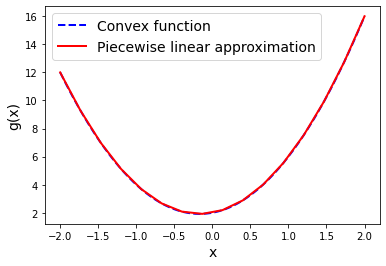

In [8]:
num_pieces = 15
x_min = -2
x_max = 2

visual_pw(func, x_min, x_max, num_pieces)

As a result, the nonlinear constraint $g(x) \leq b$ can be written as 
\begin{align}
&a_1x + d_1\leq b \\
&a_2x + d_2\leq b \\
&\vdots \\
&a_kx + d_k \leq b
\end{align}
where $k$ is the number of pieces used in approximating the convex function $g(x)$. 

### RSOME for Linear programming <a id="subsection2.3">

<div class="alert alert-block alert-success">
<b>Example 2:</b>  
    Solve the linear programming problem:
\begin{align}
\text{max}~&3x_1 + 4x_2   \\
\text{s.t.}~& 2.5x_1 +x_2 \leq 20 \\
& 5x_1 + 3x_2 \leq 30 \\
& x_1 + 2x_2 \leq 16. \\
\end{align}
</div>

Among many packages capable of solving linear programming problems, RSOME might be the most convenient one because it is compatible with NumPy N-dimensional arrays. 

In [9]:
model = ro.Model()

x1 = model.dvar()                   # Define a decision variable x1
x2 = model.dvar()                   # Define a decision variable x2

model.max(3*x1 + 4*x2)              # Maximize the objective function
model.st(2.5*x1 + x2 <= 20)         # Specify the 1st constraints
model.st(5*x1 + 3*x2 <= 30)         # Specify the 2nd constraints
model.st(x1 + 2*x2 <= 16)           # Specify the 3rd constraints

model.solve(ort)                    # Solve the model by OR-Tools

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0055s


The optimal solution can be retrieved by the `get()` method of decision variables.

In [6]:
print(x1.get())
print(x2.get())

[1.71428571]
[7.14285714]


The corresponding objective value is given by the `get()` method of the model object.

In [7]:
model.get()

33.71428571428572

An alternative method is to define $x1$ and $x2$ as an array of decision variables.

In [8]:
model = ro.Model()

x = model.dvar(2)                   # Define x1 and x2 as an array

model.max(3*x[0] + 4*x[1])          # Maximize the objective function
model.st(2.5*x[0] + x[1] <= 20)     # Specify the 1st constraints
model.st(5*x[0] + 3*x[1] <= 30)     # Specify the 2nd constraints
model.st(x[0] + 2*x[1] <= 16)       # Specify the 3rd constraints

model.solve(ort)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0005s


In [9]:
x.get()

array([1.71428571, 7.14285714])

A third method is to define model parameters as arrays, and the linear programming problem is specified by NumPy-style array operations. 

In [10]:
c = np.array([3, 4])                # Coefficient of the objective function
b = np.array([20, 30, 16])          # Right-hand-side coefficients of constraints
A = np.array([[2.5, 1],
              [5, 3],
              [1, 2]])              # Left-hand-side coefficients of constraints

model = ro.Model()

x = model.dvar(2)

model.max((c*x).sum())
model.st((A*x).sum(axis=1) <= b)

model.solve(ort)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0005s


In [11]:
x.get()

array([1.71428571, 7.14285714])

The third method would be preferred if model parameters are provided in data frames or NumPy arrays. 

<div class="alert alert-block alert-success">
<b>Example 3:</b>  
The following table provides the cost and nutrition values of four different types of food. Find a minimum-cost diet that contains at least 1) 500 calories; 2) 6 grams of chocolate; 3) 10 grams of sugar; and 4) 8 grams of fat. 
</div>

In [10]:
diet_dict = {'Brownies': [400, 3, 2, 2, 0.5],
             'Ice Cream': [200, 2, 2, 4, 0.2], 
             'Cola': [150, 0, 4, 1, 0.3],
             'Cheese Cake': [500, 0, 4, 5, 0.8]}
diet = pd.DataFrame(diet_dict, 
                    index=['Calories', 'Chocolate', 'Sugar', 'Fat', 'Cost'])
diet

,Brownies,Ice Cream,Cola,Cheese Cake
Calories,400.0,200.0,150.0,500.0
Chocolate,3.0,2.0,0.0,0.0
Sugar,2.0,2.0,4.0,4.0
Fat,2.0,4.0,1.0,5.0
Cost,0.5,0.2,0.3,0.8


In [11]:
diet_array = diet.values
diet_array

array([[4.0e+02, 2.0e+02, 1.5e+02, 5.0e+02],
       [3.0e+00, 2.0e+00, 0.0e+00, 0.0e+00],
       [2.0e+00, 2.0e+00, 4.0e+00, 4.0e+00],
       [2.0e+00, 4.0e+00, 1.0e+00, 5.0e+00],
       [5.0e-01, 2.0e-01, 3.0e-01, 8.0e-01]])

In [14]:
nutrition = np.array([500, 6, 10, 8])
nutrition

array([500,   6,  10,   8])

Let $\pmb{A}$ be the two-dimensional array given by the table `diet_array`, $\pmb{b}$ be the one-dimensional array `nutrition`, then diet problem can be formulated as
\begin{align}
\min~&A_{41}x_1 + A_{42}x_2 + A_{43}x_3 + A_{44}x_4 \\
\text{s.t.}~&A_{01}x_1 + A_{02}x_2 + A_{03}x_3 + A_{04}x_4 \geq b_0 \\
&A_{11}x_1 + A_{12}x_2 + A_{13}x_3 + A_{14}x_4 \geq b_1 \\
&A_{21}x_1 + A_{22}x_2 + A_{23}x_3 + A_{24}x_4 \geq b_2 \\
&A_{31}x_1 + A_{32}x_2 + A_{33}x_3 + A_{34}x_4 \geq b_3 \\
&x_1, x_2, x_3, x_4 \geq 0.
\end{align}
where $x_i$ is the quantity of the $i$th food. Such a linear programming problem can be solved by the following code. 

In [15]:
diet_array[:-1, :]

array([[400., 200., 150., 500.],
       [  3.,   2.,   0.,   0.],
       [  2.,   2.,   4.,   4.],
       [  2.,   4.,   1.,   5.]])

In [16]:
model = ro.Model()

x = model.dvar(4)                   # Define decision variables

model.min((diet_array[-1, :]*x).sum())
model.st((diet_array[:-1, :]*x).sum(axis=1) >= nutrition)
model.st(x >= 0)
model.solve(ort)

pd.Series(x.get(), 
          index=['Brownies', 'Ice Cream', 'Cola', 'Cheese Cake'])

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0007s


Brownies       0.0
Ice Cream      3.0
Cola           1.0
Cheese Cake    0.0
dtype: float64

If you are familiar with linear algebra, the model can be coded in a more concise way. 

In [17]:
model = ro.Model()

x = model.dvar(4)                   # Define decision variables

model.min(diet_array[-1, :] @ x)
model.st(diet_array[:-1, :] @ x >= nutrition)
model.st(x >= 0)
model.solve(ort)

pd.Series(x.get(), 
          index=['Brownies', 'Ice Cream', 'Cola', 'Cheese Cake'])

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0004s


Brownies       0.0
Ice Cream      3.0
Cola           1.0
Cheese Cake    0.0
dtype: float64

<div class="alert alert-block alert-success">
<b>Example 4:</b>  
A company has three PC assembly plants at locations a, b, and c, with monthly production capacity of 1700 units, 2000 units, and 1700 units, respectively. Their PC's are sold through four retail outlets in locations A, B, C, and D, with monthly orders of 1700 units, 1000 units, 1500 units, and 1200 units respectively. The shipping costs from each plant to each outlet are presented in the following table. Use a linear programming model to find out the optimal shipping decision.  
</div>

In [15]:
ship_cost = pd.DataFrame([[5, 4, 2, 6],
                          [7, 7, 8, 10], 
                          [6, 5, 3, 8]], 
                         index=['a', 'b', 'c'], 
                         columns=['A', 'B', 'C', 'D'])
ship_cost

,A,B,C,D
a,5,4,2,6
b,7,7,8,10
c,6,5,3,8


The linear programming problem can be written as

\begin{align}
\min~&\sum\limits_{i=0}^2\sum\limits_{j=0}^3A_{ij}x_{ij}&& \\
\text{s.t.}~&x_{i0} + x_{i1} + x_{i2} +x_{i3}\leq c_i &&i=0, 1, 2 \\
&x_{0j} + x_{1j} + x_{2j} \geq d_j && j=0, 1, 2, 3 \\
&x_{ij} \geq 0 && i=0, 1, 2 \text{ and } j=0, 1, 2, 3
\end{align}

where $\pmb{c}=\{1700, 2000, 1700\}$ is the array of production capacities, and $\pmb{d}=\{1700, 1000, 1500, 1200\}$ is the array of orders at different locations. The decision variable $x_{ij}$ is amount of products transported from location $i$ to location $j$. The model can be thus built as below.

In [16]:
A = ship_cost.values
c = np.array([1700, 2000, 1700])
d = np.array([1700, 1000, 1500, 1200])

model = ro.Model()

x = model.dvar((3, 4))      

model.min((A * x).sum())
model.st(x.sum(axis=1) <= c)
model.st(x.sum(axis=0) >= d)
model.st(x >= 0)
model.solve(ort)

pd.DataFrame(x.get(), 
             index=['a', 'b', 'c'], 
             columns=['A', 'B', 'C', 'D'])

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0024s


,A,B,C,D
a,0.0,0.0,500.0,1200.0
b,1700.0,300.0,0.0,0.0
c,0.0,700.0,1000.0,0.0


## Decision-making under uncertainty <a id="section3"></a>

In all previous examples, it is assumed that all model parameters are certain, or deterministic. Apparently, such an assumption does not hold in many applications. For example, when deciding the order quantity of a product, the demand is usually unknown, and a deterministic model many lead to sub-optimal solutions. 

<div class="alert alert-block alert-success">
<b>Example 5:</b>  
This example considers a multi-item newsvendor problem. The historical data of five product items are provided in the file 'newspaper_demand.csv'. The order cost for these products are all $\$1$, and the selling prices are $\$1.2$, $\$1.25$, $\$1.5$, $\$1.7$, and $\$1.85$, respectively. If the budget of ordering these products is $\$425$, what are the optimal order quantities that maximize the profit?
</div>

In [23]:
demand = pd.read_csv('newspaper_demand.csv')
demand

,Item 1,Item 2,Item 3,Item 4,Item 5
0,269.323584,220.415121,293.304252,244.224456,189.486576
1,269.380246,251.620978,199.156070,193.071955,247.120274
2,252.820126,209.256886,234.173245,252.964251,143.988357
3,296.700322,277.800148,247.238449,202.779095,282.857073
4,229.330348,282.132690,254.490050,240.405708,146.547521
...,...,...,...,...,...
495,249.297996,122.211862,237.859906,203.635937,245.134135
496,311.710657,205.867389,225.807955,156.821242,168.385928
497,216.286850,240.101741,241.939460,249.046962,272.675370
498,264.283833,173.247978,156.602299,177.087376,150.251672


In [24]:
cost = np.ones(5)
price = np.array([1.2, 1.25, 1.5, 1.7, 1.85])
budget = 425

A simple and straightforward method to deal with the uncertain demand in the optimization model is to consider the average of the demand in constraints, so the newsvendor problem can be easily formulated as a deterministic model:

\begin{align}
\max~&\sum\limits_{i=0}^4(p_iy_i - c_ix_i) &&\\
\text{s.t.}~ &x_i \geq 0 &&i = 0, 1, 2, 3, 4 \\
&\sum\limits_{i=0}^4c_ix_i \leq b && \\
& y_i \leq x_i && i = 0, 1, 2, 3, 4 \\
& y_i \leq \bar{d}_i && i = 0, 1, 2, 3, 4, 
\end{align}
where the parameters:
- $p_i$: the price of product item $i$;
- $c_i$: the cost of product item $i$;
- $b$: the budget of ordering products;
- $\bar{d}_i$: the average demand of product item $i$,

and the decision variables:
- $x_i$: the order quantity of product item $i$;
- $y_i$: the sold quantity of product item $i$.

The model can be thus written as the function `det_mdoel` which returns the optimal order quantities.

In [25]:
def det_model(cost, price, demand, budget):
    '''
    The function det_model solves the optimal order quantities by applying the 
    average demand in the constriants.
    '''
    model = ro.Model()

    n = len(price)
    x = model.dvar(n, vtype='I')
    y = model.dvar(n, vtype='I')

    model.max((price*y - cost*x).sum())
    model.st(x >= 0)
    model.st((cost*x).sum() <= budget)
    model.st(y <= x)
    model.st(y <= demand.mean().values)
    
    model.solve(ort, display=False)

    return pd.Series(x.get(), index=demand.columns)

In the function above, the keyword argument `vtype='I'` is used to indicate that the decision variable `x` and `y` are integers. The optimal order quantity solved by the deterministic model is given below.

In [26]:
order = det_model(cost, price, demand, budget)
order

Item 1      0.0
Item 2      0.0
Item 3      9.0
Item 4    213.0
Item 5    203.0
dtype: float64

The function `mc_sim()` is used to calculate the total profits for each demand record for a given order decision.

In [27]:
def mc_sim(cost, price, order, demand):
    
    demand_val = demand.values
    sold = np.minimum(order, demand_val)
    profits = (sold * price - order*cost).sum(axis=1)
    
    return profits

In [30]:
profits.shape

(500,)

In [28]:
profits = mc_sim(cost, price, order.values, demand)
profits.mean()          # Average profit

265.16505886843385

A more advanced method is the stochastic programming, which calculates the profit for each demand realization, and uses the average profit as the objective function. The formula is written as:

\begin{align}
\max~&\frac{1}{s}\sum\limits_{j=0}^{s-1}\sum\limits_{i=0}^4p_iy_{ji} - \sum\limits_{i=0}^4 c_ix_i && &&\\
\text{s.t.}~ &x_i \geq 0 &&i = 0, 1, 2, 3, 4 &&\\
&\sum\limits_{i=0}^4c_ix_i \leq b && &&\\
& y_{ji} \leq x_i && i = 0, 1, 2, 3, 4 && j = 0, 1, ..., s-1\\
& y_{ji} \leq d_{ji} && i = 0, 1, 2, 3, 4, && j = 0, 1, ..., s-1 
\end{align}

where $s$ is size of the demand dataset, and the parameters:
- $p_i$: the price of product item $i$;
- $c_i$: the cost of product item $i$;
- $b$: the budget of ordering products;
- $d_{ji}$: the demand of product item $i$, as the $j$th record,

and the decision variables:
- $x_i$: the order quantity of product item $i$;
- $y_{ji}$: the sold quantity of product item $i$, under the $j$th record of the demand.

The model is coded as the function `sto_model()`.

In [26]:
def sto_model(cost, price, demand, budget):
    '''
    The function sto_model solves the optimal order quantities by a stochastic model
    '''
    
    model = ro.Model()

    n = 5
    s = demand.shape[0]
    x = model.dvar(n, vtype='I')
    y = model.dvar((s, n), vtype='I')

    model.max((1/s) * (price*y - cost*x).sum())
    model.st(x >= 0)
    model.st(y <= x)
    model.st(y <= demand.values)
    model.st((cost*x).sum() <= budget)

    model.solve(ort, display=False)

    return pd.Series(x.get(), index=demand.columns)

Please note that we are specifying the keyword argument `vtype='I'` so that decision variable `x` and `y` are integers. 

In [27]:
order = sto_model(cost, price, demand, budget)
order

Item 1      0.0
Item 2      0.0
Item 3    103.0
Item 4    160.0
Item 5    162.0
dtype: float64

It can be seen that the decision for the stochastic model is different from the deterministic one, and we have the average profit to be improved, as shown below.

In [28]:
profits = mc_sim(cost, price, order.values, demand)
profits.mean()

290.08737645057107

In fact, we can vary the budget value, and assess the performance in terms of the average profits for both models, and the results are shown below. 

In [29]:
step = 50
budgets = np.arange(200, 1500+step, step)

profits_det = []
profits_sto = []
for budget in budgets: 
    order_det = det_model(cost, price, demand, budget)
    order_val = order_det.values
    profits_det.append(mc_sim(cost, price, order_val, demand).mean())
    
    order_sto = sto_model(cost, price, demand, budget)
    order_val = order_sto.values
    profits_sto.append(mc_sim(cost, price, order_val, demand).mean())
    

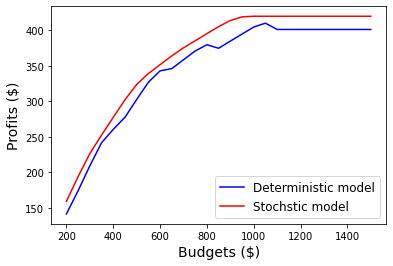

In [30]:
plt.plot(budgets, profits_det, color='b', label='Deterministic model')
plt.plot(budgets, profits_sto, color='r', label='Stochstic model')

plt.legend(fontsize=12)
plt.xlabel('Budgets ($)', fontsize=14)
plt.ylabel('Profits ($)', fontsize=14)
plt.show()

This example shows that the stochastic model would outperform the deterministic model.

## Case study <a id="section4"></a>

### Task 1

A furniture company is producing four types furniture: chairs, tables, stools, and shelves. All furniture products involves three operations: plaining, assembling, and painting. The profits of each type of furniture, and the required working minutes for each operation is presented in the table `furniture`. 

In [32]:
furniture = pd.DataFrame([[12.0, 18.0, 16.0, 30.0],
                          [5, 10, 12, 12],
                          [6, 3, 4, 5],
                          [5, 6.25, 5, 12.5]], 
                         index=['Profit', 'Plaining', 'Assembling', 'Painting'], 
                         columns=['Chair', 'Table', 'Stool', 'Shelf'])
furniture

,Chair,Table,Stool,Shelf
Profit,12.0,18.00,16.0,30.0
Plaining,5.0,10.00,12.0,12.0
Assembling,6.0,3.00,4.0,5.0
Painting,5.0,6.25,5.0,12.5


It is assumed that the due to a license issue, this company can at most produce 1200 shelf per month, and the maximum working minutes for each operation is given in the series `cap`. 

In [33]:
cap = pd.Series([27000.0, 18000.0, 25000.0], 
                index=['Plaining', 'Assembling', 'Painting'])
cap

Plaining      27000.0
Assembling    18000.0
Painting      25000.0
dtype: float64

Write the formula of the linear programming model which maximizes the total profit. Use RSOME to implement the model.

$$
\begin{align}
\max ~ &\sum\limits_{i=1}^3A_{0i}x_i \\
\text{s.t.}~&\sum\limits_{i=1}^3A_{(j+1)i}x_i \leq c_j, &&j=0, 1, 2 \\
&x_3 \leq 1200 \\
&x_i \geq 0, &&i=0, 1, 2, 3
\end{align}
$$

In [36]:
A = furniture.values
c = cap.values

model = ro.Model()

x = model.dvar(4, vtype='I')

model.max((A[0]*x).sum())
model.st((A[1:]*x).sum(axis=1) <= c)
model.st(x[-1] <= 1200)
model.st(x >= 0)

model.solve(ort)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0071s


In [38]:
pd.Series(x.get(), index=furniture.columns)

Chair    1132.0
Table     694.0
Stool       0.0
Shelf    1200.0
dtype: float64

In [47]:
A = furniture.values
c = cap.values

model = ro.Model()

x = model.dvar(4, vtype='I')

model.max(A[0] @ x)
model.st(A[1:] @ x <= c)
model.st(x[-1] <= 1200)
model.st(x >= 0)

model.solve(ort)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0010s


In [48]:
pd.Series(x.get(), index=furniture.columns)

Chair    1132.0
Table     694.0
Stool       0.0
Shelf    1200.0
dtype: float64

In [49]:
model.get()

62075.999999999985

### Task 2

If the furniture company is paying extra for overtime, and the per minute rates are given in the series `overtime`.

In [42]:
overtime = pd.Series([2.0, 1.8, 1.5], 
                     index=['Plaining', 'Assembling', 'Painting'])
overtime

Plaining      2.0
Assembling    1.8
Painting      1.5
dtype: float64

Write the updated linear programming model, and solve it using RSOME.

$$
\begin{align}
\max ~ &\sum\limits_{i=1}^3A_{0i}x_i - \sum\limits_{j=0}^2t_jy_j\\
\text{s.t.}~&\sum\limits_{i=1}^3A_{(j+1)i}x_i \leq c_j + y_j, &&j=0, 1, 2 \\
&x_3 \leq 1200 \\
&x_i \geq 0, &&i=0, 1, 2, 3 \\
&y_j \geq 0, &&j=0, 1, 2
\end{align}
$$

In [50]:
A = furniture.values
c = cap.values
t = overtime.values

model = ro.Model()

x = model.dvar(4, vtype='I')
y = model.dvar(3)

model.max((A[0]*x).sum() -  (t*y).sum())
model.st((A[1:]*x).sum(axis=1) <= c + y)
model.st(x[-1] <= 1200)
model.st(x >= 0)
model.st(y >= 0)

model.solve(ort)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.0104s


In [51]:
pd.Series(x.get(), index=furniture.columns)

Chair    1826.0
Table     347.0
Stool       0.0
Shelf    1200.0
dtype: float64

In [52]:
pd.Series(y.get(), index=overtime.index)

Plaining         0.00
Assembling       0.00
Painting      1298.75
dtype: float64

In [53]:
model.get()

62209.8749999997

### Task 3

Due to some unforeseen factors, the maximum working time for each month is uncertain and the historical data are presented in the data frame `cap`. 

In [55]:
cap = pd.read_csv('capacity.csv')
cap

,Plaining,Assembling,Paining
0,23078.182528,14128.396244,29818.852271
1,26541.189239,7446.920996,43694.765465
2,25707.678316,17408.030565,38891.735372
3,21774.574498,23972.720907,21662.409943
4,18800.966040,14012.742371,30131.300844
...,...,...,...
195,28747.982083,23356.672678,32427.158764
196,28175.854232,22991.877715,29829.221058
197,22520.741432,18346.180014,49647.777228
198,35066.113241,18012.241629,18513.166593


Considering the overtime cost, develop a stochastic model for the furniture company to maximize the profit.

$$
\begin{align}
\max ~ &\sum\limits_{i=1}^3A_{0i}x_i - \frac{1}{s}\sum\limits_{k=0}^{s-1}\sum\limits_{j=0}^2t_jy_{kj}\\
\text{s.t.}~&\sum\limits_{i=1}^3A_{(j+1)i}x_i \leq c_{kj} + y_{kj}, &&j=0, 1, 2 & k = 0, 1, ..., s-1\\
&x_3 \leq 1200 \\
&x_i \geq 0, &&i=0, 1, 2, 3 \\
&y_{kj} \geq 0, &&j=0, 1, 2 & k = 0, 1, ..., s-1
\end{align}
$$

In [59]:
A = furniture.values
c = cap.values
t = overtime.values
s = c.shape[0]

model = ro.Model()

x = model.dvar(4, vtype='I')
y = model.dvar((s, 3))

model.max((A[0]*x).sum() -  (1/s)*(t*y).sum())
model.st((A[1:]*x).sum(axis=1) <= c + y)
model.st(x[-1] <= 1200)
model.st(x >= 0)
model.st(y >= 0)

model.solve(ort)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.1363s


In [60]:
model.get()

50366.73128388292

In [61]:
pd.Series(x.get(), index=furniture.columns)

Chair     723.0
Table    1049.0
Stool       0.0
Shelf    1200.0
dtype: float64

In [63]:
pd.DataFrame(y.get(), columns=cap.columns)

,Plaining,Assembling,Paining
0,5426.817472,0.000000,0.000000
1,1963.810761,6038.079004,0.000000
2,2797.321684,0.000000,0.000000
3,6730.425502,0.000000,3508.840057
4,9704.033960,0.000000,0.000000
...,...,...,...
195,0.000000,0.000000,0.000000
196,329.145768,0.000000,0.000000
197,5984.258568,0.000000,0.000000
198,0.000000,0.000000,6658.083407
